In [1]:
from PIL import Image
import os.path
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random

C:\Users\Public\Downloads\Anaconda\envs\AMLS\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Public\Downloads\Anaconda\envs\AMLS\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Public\Downloads\Anaconda\envs\AMLS\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Public\Downloads\Anaconda\envs\AMLS\l

In [2]:
def get_data():
    X=[]
    y=[]
    baseDir = os.path.abspath('..')
    filePath = os.path.join(baseDir ,'Datasets','celeba','img')
    filelist = os.listdir(filePath)
    labelPath = os.path.join(baseDir ,'Datasets','celeba','labels.csv') 
    labels = pd.read_csv(labelPath,delimiter = '\t')
    for item in filelist:
        path = os.path.join(filePath,item)
        img= cv2.imread(path)
        #resize image to 64*64, conver to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (64, 64)) 
        #array normalization
        X.append(np.array(img)/255.)
        #read labels according to image name
        label = labels['smiling'][int(item.split('.')[0])]
        y.append(label)
    y = np.array(y)
    #male = 1 and female =0
    Y = np.array([(y+1)/2, (1-y)/2]).T
    x_train, x_test, y_train, y_test = train_test_split(X, Y,random_state=0)

    return x_train, x_test, y_train, y_test

In [3]:
def allocate_weights_and_biases():
    #define convolution kernal numbers and neurons in hidden layers
    kernal_1 = 16
    kernal_2 = 32
    kernal_3 = 64
    hidden_1 = 512  
    hidden_2 = 128  
    
    #set placeholder for input and output
    X = tf.placeholder("float", [None, 64, 64],name = 'input_images')
    Y = tf.placeholder("float", [None, 2],name = 'result')  
    x_input = tf.reshape(X,[-1,64,64,1])
    stddev = 0.01
    
    #assign weights and biases on each layer
    weights = {
        'conv_layer1':tf.Variable(tf.random_normal([3,3,1,kernal_1], stddev=stddev)),
        'conv_layer2':tf.Variable(tf.random_normal([3,3,kernal_1,kernal_2], stddev=stddev)),
        'conv_layer3':tf.Variable(tf.random_normal([3,3,kernal_2,kernal_3], stddev=stddev)),
        'hidden_layer1': tf.Variable(tf.random_normal([64 * 64, hidden_1], stddev=stddev)),
        'hidden_layer2': tf.Variable(tf.random_normal([hidden_1, hidden_2], stddev=stddev)),
        'out': tf.Variable(tf.random_normal([hidden_2, 2], stddev=stddev))
    }

    biases = {
        'bias_ConvLayer1':tf.Variable(tf.random_normal([kernal_1], stddev=stddev)),
        'bias_ConvLayer2':tf.Variable(tf.random_normal([kernal_2], stddev=stddev)),
        'bias_ConvLayer3':tf.Variable(tf.random_normal([kernal_3], stddev=stddev)),
        'bias_layer1': tf.Variable(tf.random_normal([hidden_1], stddev=stddev)),
        'bias_layer2': tf.Variable(tf.random_normal([hidden_2], stddev=stddev)),
        'out': tf.Variable(tf.random_normal([2], stddev=stddev))
    }
    
    return weights, biases, X, Y,x_input
    

In [4]:
def multilayer_perceptron():       
    weights, biases, X, Y, x_input = allocate_weights_and_biases()
    #build and connect layers
    layer_1 = tf.add(tf.nn.conv2d(x_input, weights['conv_layer1'],strides=[1,1,1,1],padding='SAME'), biases['bias_ConvLayer1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.max_pool(layer_1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

    layer_2 = tf.add(tf.nn.conv2d(layer_1, weights['conv_layer2'],strides=[1,1,1,1],padding='SAME'), biases['bias_ConvLayer2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_2 = tf.nn.max_pool(layer_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    layer_3 = tf.add(tf.nn.conv2d(layer_2, weights['conv_layer3'],strides=[1,1,1,1],padding='SAME'), biases['bias_ConvLayer3'])
    layer_3 = tf.nn.relu(layer_3)
    layer_3 = tf.nn.max_pool(layer_3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    flat =  tf.contrib.layers.flatten(layer_3)  
    full_layer1 = tf.add(tf.matmul(flat,weights['hidden_layer1']),biases['bias_layer1'])
    full_layer1 = tf.nn.relu(full_layer1)
    full_layer1 = tf.nn.dropout(full_layer1,0.5)
    
    full_layer2 = tf.add(tf.matmul(full_layer1,weights['hidden_layer2']),biases['bias_layer2'])
    full_layer2 = tf.nn.relu(full_layer2)
    full_layer2 = tf.nn.dropout(full_layer2,0.5)
    
    out_layer = tf.matmul(full_layer2, weights['out']) + biases['out']
    out_layer = tf.nn.softmax(out_layer)

    return out_layer, X, Y

In [5]:
x_train, x_test, y_train, y_test = get_data()

In [6]:
tf.reset_default_graph()
global_step = tf.Variable(0, trainable=False)
#set learning rate, training epochs adn model save step.
learning_rate = tf.train.exponential_decay(1e-4,  global_step, decay_steps=500, decay_rate=0.5,staircase=True)
training_epochs = 10000
display_accuracy_step = 10
save_step = 100

In [7]:
import matplotlib.pyplot as plt
logits, X, Y = multilayer_perceptron()
#build tensors including loss,acc and predict_label
variables   = tf.trainable_variables() 
lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in variables ]) * 1e-4
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y)+lossL2,name = 'loss')
predict_label = tf.argmax(logits, 1,name = 'predict_label')
true_prediction = tf.equal(predict_label, tf.argmax(Y, 1),name = 'check')
acc = tf.reduce_mean(tf.cast(true_prediction, "float"),name = 'acc')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
init_op = tf.global_variables_initializer()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [20]:
saver = tf.train.Saver(max_to_keep=4)
train_acc=[]
val_acc = []
with tf.Session() as sess:
    sess.run(init_op)
    for epoch in range(training_epochs):
        #set batch components
        idx=random.randint(0,3686)
        batch= random.randint(32,65)
        train_input = x_train[idx:(idx+batch)]
        train_labels = y_train[idx:(idx+batch)]
        
        accuracy, _ , cost = sess.run([acc, train_op, loss_op], feed_dict={X: train_input,Y: train_labels})
        print("Epoch:", '%04d' % (epoch + 1), "cost={:.9f}".format(cost))
        #add acc into arrays and wait for visualization
        train_acc.append(acc.eval({X: x_train,Y: y_train}))
        val_acc.append(acc.eval({X: x_test,Y: y_test}))
        if ((epoch+1) % display_accuracy_step == 0):
            print("Train Accuracy:", accuracy)  
        #save model
        if ((epoch+1) % save_step == 0 ):
            saver.save(sess, "model/smiling-model", global_step=epoch)   
            
    print("Optimization Finished!")
    print("Test Accuracy:", acc.eval({X: x_test,Y: y_test}))

Epoch: 0001 cost=0.692664862
Epoch: 0002 cost=0.693732619
Epoch: 0003 cost=0.692268610
Epoch: 0004 cost=0.693584442
Epoch: 0005 cost=0.692883790
Epoch: 0006 cost=0.691287994
Epoch: 0007 cost=0.693221867
Epoch: 0008 cost=0.692237556
Epoch: 0009 cost=0.694438815
Epoch: 0010 cost=0.694620192
Train Accuracy: 0.42592594
Epoch: 0011 cost=0.692476153
Epoch: 0012 cost=0.692320526
Epoch: 0013 cost=0.693190753
Epoch: 0014 cost=0.692934334
Epoch: 0015 cost=0.693872929
Epoch: 0016 cost=0.694701552
Epoch: 0017 cost=0.694938838
Epoch: 0018 cost=0.693394721
Epoch: 0019 cost=0.692517042
Epoch: 0020 cost=0.690911114
Train Accuracy: 0.6486486
Epoch: 0021 cost=0.693387032
Epoch: 0022 cost=0.691811919
Epoch: 0023 cost=0.694194853
Epoch: 0024 cost=0.693642616
Epoch: 0025 cost=0.692627907
Epoch: 0026 cost=0.692634225
Epoch: 0027 cost=0.692979753
Epoch: 0028 cost=0.692341745
Epoch: 0029 cost=0.694555879
Epoch: 0030 cost=0.693092763
Train Accuracy: 0.51724136
Epoch: 0031 cost=0.695008814
Epoch: 0032 cost=0.69

Epoch: 0262 cost=0.693722129
Epoch: 0263 cost=0.693597376
Epoch: 0264 cost=0.692866027
Epoch: 0265 cost=0.693533778
Epoch: 0266 cost=0.693082809
Epoch: 0267 cost=0.692165315
Epoch: 0268 cost=0.693955362
Epoch: 0269 cost=0.692148924
Epoch: 0270 cost=0.692070246
Train Accuracy: 0.5813953
Epoch: 0271 cost=0.692547739
Epoch: 0272 cost=0.693742692
Epoch: 0273 cost=0.692064583
Epoch: 0274 cost=0.692969203
Epoch: 0275 cost=0.693662763
Epoch: 0276 cost=0.694668233
Epoch: 0277 cost=0.692104757
Epoch: 0278 cost=0.692343950
Epoch: 0279 cost=0.694479942
Epoch: 0280 cost=0.694093645
Train Accuracy: 0.4385965
Epoch: 0281 cost=0.693920076
Epoch: 0282 cost=0.693643510
Epoch: 0283 cost=0.695180714
Epoch: 0284 cost=0.693448544
Epoch: 0285 cost=0.693924963
Epoch: 0286 cost=0.693430841
Epoch: 0287 cost=0.693497062
Epoch: 0288 cost=0.691470563
Epoch: 0289 cost=0.691650689
Epoch: 0290 cost=0.693920195
Train Accuracy: 0.4509804
Epoch: 0291 cost=0.693812966
Epoch: 0292 cost=0.692632020
Epoch: 0293 cost=0.6933

Epoch: 0522 cost=0.691928208
Epoch: 0523 cost=0.692959845
Epoch: 0524 cost=0.692978799
Epoch: 0525 cost=0.694921970
Epoch: 0526 cost=0.692971289
Epoch: 0527 cost=0.693798482
Epoch: 0528 cost=0.693642378
Epoch: 0529 cost=0.693909347
Epoch: 0530 cost=0.694333255
Train Accuracy: 0.4181818
Epoch: 0531 cost=0.692058027
Epoch: 0532 cost=0.694403648
Epoch: 0533 cost=0.689715624
Epoch: 0534 cost=0.692705035
Epoch: 0535 cost=0.692634881
Epoch: 0536 cost=0.693859339
Epoch: 0537 cost=0.693590045
Epoch: 0538 cost=0.692971468
Epoch: 0539 cost=0.694555521
Epoch: 0540 cost=0.693259299
Train Accuracy: 0.4918033
Epoch: 0541 cost=0.694546640
Epoch: 0542 cost=0.692650497
Epoch: 0543 cost=0.692664802
Epoch: 0544 cost=0.693519354
Epoch: 0545 cost=0.693962693
Epoch: 0546 cost=0.693128109
Epoch: 0547 cost=0.694317937
Epoch: 0548 cost=0.692861140
Epoch: 0549 cost=0.692692041
Epoch: 0550 cost=0.693743646
Train Accuracy: 0.46153846
Epoch: 0551 cost=0.692947388
Epoch: 0552 cost=0.694786012
Epoch: 0553 cost=0.692

Epoch: 0782 cost=0.693360984
Epoch: 0783 cost=0.692606628
Epoch: 0784 cost=0.692923129
Epoch: 0785 cost=0.693085968
Epoch: 0786 cost=0.693148196
Epoch: 0787 cost=0.693426371
Epoch: 0788 cost=0.692923009
Epoch: 0789 cost=0.693328083
Epoch: 0790 cost=0.694243312
Train Accuracy: 0.38333333
Epoch: 0791 cost=0.693127334
Epoch: 0792 cost=0.692356467
Epoch: 0793 cost=0.693274379
Epoch: 0794 cost=0.692424119
Epoch: 0795 cost=0.693118870
Epoch: 0796 cost=0.692481995
Epoch: 0797 cost=0.691807032
Epoch: 0798 cost=0.692615151
Epoch: 0799 cost=0.691442072
Epoch: 0800 cost=0.693084061
Train Accuracy: 0.5538462
Epoch: 0801 cost=0.693707168
Epoch: 0802 cost=0.693257093
Epoch: 0803 cost=0.693460226
Epoch: 0804 cost=0.692597866
Epoch: 0805 cost=0.692801535
Epoch: 0806 cost=0.692694247
Epoch: 0807 cost=0.693187237
Epoch: 0808 cost=0.693699837
Epoch: 0809 cost=0.692991555
Epoch: 0810 cost=0.692653060
Train Accuracy: 0.48
Epoch: 0811 cost=0.692627549
Epoch: 0812 cost=0.691925168
Epoch: 0813 cost=0.69150948

Epoch: 1042 cost=0.696521103
Epoch: 1043 cost=0.672575891
Epoch: 1044 cost=0.564549267
Epoch: 1045 cost=0.697843492
Epoch: 1046 cost=0.701272130
Epoch: 1047 cost=0.632022023
Epoch: 1048 cost=0.605312049
Epoch: 1049 cost=0.653740048
Epoch: 1050 cost=0.700760961
Train Accuracy: 0.516129
Epoch: 1051 cost=0.702664793
Epoch: 1052 cost=0.613558412
Epoch: 1053 cost=0.653084695
Epoch: 1054 cost=0.645127833
Epoch: 1055 cost=0.689048111
Epoch: 1056 cost=0.668337643
Epoch: 1057 cost=0.683453023
Epoch: 1058 cost=0.709946752
Epoch: 1059 cost=0.641924322
Epoch: 1060 cost=0.654397011
Train Accuracy: 0.6666667
Epoch: 1061 cost=0.613487720
Epoch: 1062 cost=0.624569237
Epoch: 1063 cost=0.643109083
Epoch: 1064 cost=0.662476301
Epoch: 1065 cost=0.657748818
Epoch: 1066 cost=0.584947646
Epoch: 1067 cost=0.631494105
Epoch: 1068 cost=0.631569207
Epoch: 1069 cost=0.618033826
Epoch: 1070 cost=0.582054675
Train Accuracy: 0.7297297
Epoch: 1071 cost=0.646725118
Epoch: 1072 cost=0.675890803
Epoch: 1073 cost=0.69540

Epoch: 1302 cost=0.665632486
Epoch: 1303 cost=0.626956284
Epoch: 1304 cost=0.707134604
Epoch: 1305 cost=0.719952583
Epoch: 1306 cost=0.666398525
Epoch: 1307 cost=0.681458175
Epoch: 1308 cost=0.643940687
Epoch: 1309 cost=0.658329844
Epoch: 1310 cost=0.664136231
Train Accuracy: 0.5849057
Epoch: 1311 cost=0.649177790
Epoch: 1312 cost=0.616586089
Epoch: 1313 cost=0.617799222
Epoch: 1314 cost=0.670457006
Epoch: 1315 cost=0.595558822
Epoch: 1316 cost=0.661227226
Epoch: 1317 cost=0.636907279
Epoch: 1318 cost=0.672783315
Epoch: 1319 cost=0.638368666
Epoch: 1320 cost=0.627592623
Train Accuracy: 0.65
Epoch: 1321 cost=0.663740635
Epoch: 1322 cost=0.620433450
Epoch: 1323 cost=0.619312167
Epoch: 1324 cost=0.640102267
Epoch: 1325 cost=0.651483297
Epoch: 1326 cost=0.533592582
Epoch: 1327 cost=0.635067046
Epoch: 1328 cost=0.699598074
Epoch: 1329 cost=0.687598944
Epoch: 1330 cost=0.607066989
Train Accuracy: 0.73170733
Epoch: 1331 cost=0.649168730
Epoch: 1332 cost=0.618580043
Epoch: 1333 cost=0.74489814

Epoch: 1562 cost=0.599896014
Epoch: 1563 cost=0.634052932
Epoch: 1564 cost=0.722894967
Epoch: 1565 cost=0.728287876
Epoch: 1566 cost=0.657294869
Epoch: 1567 cost=0.631463528
Epoch: 1568 cost=0.625926435
Epoch: 1569 cost=0.640071154
Epoch: 1570 cost=0.652665138
Train Accuracy: 0.6666667
Epoch: 1571 cost=0.661599100
Epoch: 1572 cost=0.605903208
Epoch: 1573 cost=0.702057719
Epoch: 1574 cost=0.595850945
Epoch: 1575 cost=0.661848545
Epoch: 1576 cost=0.636481881
Epoch: 1577 cost=0.684299588
Epoch: 1578 cost=0.672641039
Epoch: 1579 cost=0.739801824
Epoch: 1580 cost=0.649848878
Train Accuracy: 0.5882353
Epoch: 1581 cost=0.707104802
Epoch: 1582 cost=0.633016229
Epoch: 1583 cost=0.660907924
Epoch: 1584 cost=0.624230623
Epoch: 1585 cost=0.591993451
Epoch: 1586 cost=0.701736212
Epoch: 1587 cost=0.634319425
Epoch: 1588 cost=0.671440363
Epoch: 1589 cost=0.642748952
Epoch: 1590 cost=0.598236918
Train Accuracy: 0.7111111
Epoch: 1591 cost=0.632516801
Epoch: 1592 cost=0.729732752
Epoch: 1593 cost=0.7530

Epoch: 1822 cost=0.653554022
Epoch: 1823 cost=0.607583821
Epoch: 1824 cost=0.668105125
Epoch: 1825 cost=0.661455870
Epoch: 1826 cost=0.643204331
Epoch: 1827 cost=0.691623926
Epoch: 1828 cost=0.718041718
Epoch: 1829 cost=0.660945058
Epoch: 1830 cost=0.658335924
Train Accuracy: 0.53125
Epoch: 1831 cost=0.698199034
Epoch: 1832 cost=0.656588256
Epoch: 1833 cost=0.700909793
Epoch: 1834 cost=0.661955595
Epoch: 1835 cost=0.685735822
Epoch: 1836 cost=0.644356251
Epoch: 1837 cost=0.632310331
Epoch: 1838 cost=0.714324355
Epoch: 1839 cost=0.716410279
Epoch: 1840 cost=0.714146852
Train Accuracy: 0.5510204
Epoch: 1841 cost=0.678668380
Epoch: 1842 cost=0.656386435
Epoch: 1843 cost=0.648079216
Epoch: 1844 cost=0.645207107
Epoch: 1845 cost=0.604962885
Epoch: 1846 cost=0.680958331
Epoch: 1847 cost=0.708720446
Epoch: 1848 cost=0.666021645
Epoch: 1849 cost=0.606820643
Epoch: 1850 cost=0.599633455
Train Accuracy: 0.6666667
Epoch: 1851 cost=0.650501609
Epoch: 1852 cost=0.653236091
Epoch: 1853 cost=0.618049

Epoch: 2082 cost=0.683713496
Epoch: 2083 cost=0.644712389
Epoch: 2084 cost=0.644648373
Epoch: 2085 cost=0.683451831
Epoch: 2086 cost=0.699295878
Epoch: 2087 cost=0.731456459
Epoch: 2088 cost=0.657941461
Epoch: 2089 cost=0.598951817
Epoch: 2090 cost=0.724755168
Train Accuracy: 0.51428574
Epoch: 2091 cost=0.653685510
Epoch: 2092 cost=0.577393711
Epoch: 2093 cost=0.602429569
Epoch: 2094 cost=0.641442835
Epoch: 2095 cost=0.638033569
Epoch: 2096 cost=0.646983266
Epoch: 2097 cost=0.610598385
Epoch: 2098 cost=0.597917140
Epoch: 2099 cost=0.662633836
Epoch: 2100 cost=0.671353698
Train Accuracy: 0.55932206
Epoch: 2101 cost=0.647012353
Epoch: 2102 cost=0.638731122
Epoch: 2103 cost=0.656630635
Epoch: 2104 cost=0.659698248
Epoch: 2105 cost=0.682306051
Epoch: 2106 cost=0.622513652
Epoch: 2107 cost=0.686789215
Epoch: 2108 cost=0.655039787
Epoch: 2109 cost=0.584160447
Epoch: 2110 cost=0.636361599
Train Accuracy: 0.6486486
Epoch: 2111 cost=0.635077477
Epoch: 2112 cost=0.588804424
Epoch: 2113 cost=0.60

Epoch: 2342 cost=0.626910269
Epoch: 2343 cost=0.617367625
Epoch: 2344 cost=0.596439242
Epoch: 2345 cost=0.622419536
Epoch: 2346 cost=0.660792887
Epoch: 2347 cost=0.578233123
Epoch: 2348 cost=0.592737377
Epoch: 2349 cost=0.589891613
Epoch: 2350 cost=0.668073356
Train Accuracy: 0.5777778
Epoch: 2351 cost=0.628735602
Epoch: 2352 cost=0.617270648
Epoch: 2353 cost=0.651642501
Epoch: 2354 cost=0.621221900
Epoch: 2355 cost=0.587915897
Epoch: 2356 cost=0.716971695
Epoch: 2357 cost=0.633095205
Epoch: 2358 cost=0.717474639
Epoch: 2359 cost=0.599130511
Epoch: 2360 cost=0.627352178
Train Accuracy: 0.6551724
Epoch: 2361 cost=0.598357260
Epoch: 2362 cost=0.689624310
Epoch: 2363 cost=0.702449262
Epoch: 2364 cost=0.672143221
Epoch: 2365 cost=0.563272834
Epoch: 2366 cost=0.620386422
Epoch: 2367 cost=0.610421240
Epoch: 2368 cost=0.652274132
Epoch: 2369 cost=0.639157474
Epoch: 2370 cost=0.609329045
Train Accuracy: 0.6727273
Epoch: 2371 cost=0.565145254
Epoch: 2372 cost=0.670425236
Epoch: 2373 cost=0.6171

Epoch: 2602 cost=0.619734168
Epoch: 2603 cost=0.611427903
Epoch: 2604 cost=0.613329589
Epoch: 2605 cost=0.623799920
Epoch: 2606 cost=0.632580221
Epoch: 2607 cost=0.677462876
Epoch: 2608 cost=0.594643414
Epoch: 2609 cost=0.576000392
Epoch: 2610 cost=0.699913800
Train Accuracy: 0.54545456
Epoch: 2611 cost=0.589098871
Epoch: 2612 cost=0.565219760
Epoch: 2613 cost=0.635112464
Epoch: 2614 cost=0.563639700
Epoch: 2615 cost=0.623351634
Epoch: 2616 cost=0.668192983
Epoch: 2617 cost=0.562567651
Epoch: 2618 cost=0.622684002
Epoch: 2619 cost=0.646817267
Epoch: 2620 cost=0.565393209
Train Accuracy: 0.71875
Epoch: 2621 cost=0.628824294
Epoch: 2622 cost=0.572145700
Epoch: 2623 cost=0.601721883
Epoch: 2624 cost=0.612709165
Epoch: 2625 cost=0.488498151
Epoch: 2626 cost=0.570074201
Epoch: 2627 cost=0.603815019
Epoch: 2628 cost=0.631908476
Epoch: 2629 cost=0.659799159
Epoch: 2630 cost=0.599532843
Train Accuracy: 0.6938776
Epoch: 2631 cost=0.587809741
Epoch: 2632 cost=0.574729264
Epoch: 2633 cost=0.69799

Epoch: 2862 cost=0.537514269
Epoch: 2863 cost=0.631818473
Epoch: 2864 cost=0.584061503
Epoch: 2865 cost=0.544966221
Epoch: 2866 cost=0.547586977
Epoch: 2867 cost=0.551347435
Epoch: 2868 cost=0.633664608
Epoch: 2869 cost=0.565858126
Epoch: 2870 cost=0.580748200
Train Accuracy: 0.70212764
Epoch: 2871 cost=0.572915018
Epoch: 2872 cost=0.489559621
Epoch: 2873 cost=0.652938306
Epoch: 2874 cost=0.609269023
Epoch: 2875 cost=0.538115442
Epoch: 2876 cost=0.587999582
Epoch: 2877 cost=0.597890615
Epoch: 2878 cost=0.547094047
Epoch: 2879 cost=0.640903652
Epoch: 2880 cost=0.523378789
Train Accuracy: 0.7941176
Epoch: 2881 cost=0.639409840
Epoch: 2882 cost=0.547998965
Epoch: 2883 cost=0.614858806
Epoch: 2884 cost=0.520786166
Epoch: 2885 cost=0.520474672
Epoch: 2886 cost=0.642365634
Epoch: 2887 cost=0.517135501
Epoch: 2888 cost=0.593360066
Epoch: 2889 cost=0.479064047
Epoch: 2890 cost=0.693462491
Train Accuracy: 0.575
Epoch: 2891 cost=0.521145940
Epoch: 2892 cost=0.601372004
Epoch: 2893 cost=0.6249479

Epoch: 3122 cost=0.456539154
Epoch: 3123 cost=0.626981378
Epoch: 3124 cost=0.517458916
Epoch: 3125 cost=0.605883479
Epoch: 3126 cost=0.618999124
Epoch: 3127 cost=0.580673099
Epoch: 3128 cost=0.582762778
Epoch: 3129 cost=0.566130757
Epoch: 3130 cost=0.538524210
Train Accuracy: 0.8181818
Epoch: 3131 cost=0.584369481
Epoch: 3132 cost=0.559716880
Epoch: 3133 cost=0.521380126
Epoch: 3134 cost=0.648107052
Epoch: 3135 cost=0.620896697
Epoch: 3136 cost=0.587131917
Epoch: 3137 cost=0.562029779
Epoch: 3138 cost=0.570506632
Epoch: 3139 cost=0.535221934
Epoch: 3140 cost=0.618865728
Train Accuracy: 0.7105263
Epoch: 3141 cost=0.554261565
Epoch: 3142 cost=0.591704369
Epoch: 3143 cost=0.581187427
Epoch: 3144 cost=0.556039095
Epoch: 3145 cost=0.626565039
Epoch: 3146 cost=0.571291387
Epoch: 3147 cost=0.596402228
Epoch: 3148 cost=0.519365847
Epoch: 3149 cost=0.596495867
Epoch: 3150 cost=0.507963896
Train Accuracy: 0.75
Epoch: 3151 cost=0.559861064
Epoch: 3152 cost=0.567110002
Epoch: 3153 cost=0.577656329

Epoch: 3382 cost=0.650100529
Epoch: 3383 cost=0.577199697
Epoch: 3384 cost=0.554610074
Epoch: 3385 cost=0.588735342
Epoch: 3386 cost=0.554760098
Epoch: 3387 cost=0.620252311
Epoch: 3388 cost=0.482121915
Epoch: 3389 cost=0.535546362
Epoch: 3390 cost=0.575092554
Train Accuracy: 0.7222222
Epoch: 3391 cost=0.493902862
Epoch: 3392 cost=0.551368833
Epoch: 3393 cost=0.561880291
Epoch: 3394 cost=0.503909886
Epoch: 3395 cost=0.660575271
Epoch: 3396 cost=0.491759241
Epoch: 3397 cost=0.482386202
Epoch: 3398 cost=0.498551399
Epoch: 3399 cost=0.548126101
Epoch: 3400 cost=0.543135345
Train Accuracy: 0.7619048
Epoch: 3401 cost=0.507429361
Epoch: 3402 cost=0.593615353
Epoch: 3403 cost=0.616251111
Epoch: 3404 cost=0.534851193
Epoch: 3405 cost=0.597786427
Epoch: 3406 cost=0.543169677
Epoch: 3407 cost=0.622942507
Epoch: 3408 cost=0.627478063
Epoch: 3409 cost=0.472957909
Epoch: 3410 cost=0.509972394
Train Accuracy: 0.79591835
Epoch: 3411 cost=0.572028995
Epoch: 3412 cost=0.604879439
Epoch: 3413 cost=0.560

Epoch: 3642 cost=0.585247099
Epoch: 3643 cost=0.582945168
Epoch: 3644 cost=0.472521007
Epoch: 3645 cost=0.520376384
Epoch: 3646 cost=0.516152084
Epoch: 3647 cost=0.526443005
Epoch: 3648 cost=0.426386535
Epoch: 3649 cost=0.528084993
Epoch: 3650 cost=0.568007290
Train Accuracy: 0.6976744
Epoch: 3651 cost=0.490240246
Epoch: 3652 cost=0.582441628
Epoch: 3653 cost=0.505396962
Epoch: 3654 cost=0.543044269
Epoch: 3655 cost=0.529349804
Epoch: 3656 cost=0.537585139
Epoch: 3657 cost=0.543738186
Epoch: 3658 cost=0.622181714
Epoch: 3659 cost=0.535637975
Epoch: 3660 cost=0.566959620
Train Accuracy: 0.7619048
Epoch: 3661 cost=0.560111403
Epoch: 3662 cost=0.470913410
Epoch: 3663 cost=0.529802322
Epoch: 3664 cost=0.562178791
Epoch: 3665 cost=0.602028847
Epoch: 3666 cost=0.562358439
Epoch: 3667 cost=0.578361869
Epoch: 3668 cost=0.549715340
Epoch: 3669 cost=0.566315413
Epoch: 3670 cost=0.568000257
Train Accuracy: 0.7
Epoch: 3671 cost=0.570674479
Epoch: 3672 cost=0.528542161
Epoch: 3673 cost=0.514648795


Epoch: 3902 cost=0.485217780
Epoch: 3903 cost=0.542643011
Epoch: 3904 cost=0.469249994
Epoch: 3905 cost=0.559378088
Epoch: 3906 cost=0.512169302
Epoch: 3907 cost=0.487946391
Epoch: 3908 cost=0.475613266
Epoch: 3909 cost=0.541068673
Epoch: 3910 cost=0.528936863
Train Accuracy: 0.7457627
Epoch: 3911 cost=0.604940951
Epoch: 3912 cost=0.541074157
Epoch: 3913 cost=0.520596623
Epoch: 3914 cost=0.503075004
Epoch: 3915 cost=0.482500553
Epoch: 3916 cost=0.561711788
Epoch: 3917 cost=0.466972798
Epoch: 3918 cost=0.585290611
Epoch: 3919 cost=0.499429017
Epoch: 3920 cost=0.537053764
Train Accuracy: 0.7258065
Epoch: 3921 cost=0.521683335
Epoch: 3922 cost=0.552839518
Epoch: 3923 cost=0.541694820
Epoch: 3924 cost=0.536301315
Epoch: 3925 cost=0.487286419
Epoch: 3926 cost=0.503283381
Epoch: 3927 cost=0.511795461
Epoch: 3928 cost=0.466058522
Epoch: 3929 cost=0.514299572
Epoch: 3930 cost=0.573108733
Train Accuracy: 0.72131145
Epoch: 3931 cost=0.488797218
Epoch: 3932 cost=0.537894487
Epoch: 3933 cost=0.505

Epoch: 4162 cost=0.470191538
Epoch: 4163 cost=0.503465354
Epoch: 4164 cost=0.528797388
Epoch: 4165 cost=0.516540706
Epoch: 4166 cost=0.508212984
Epoch: 4167 cost=0.496196270
Epoch: 4168 cost=0.532150388
Epoch: 4169 cost=0.579734802
Epoch: 4170 cost=0.498112857
Train Accuracy: 0.8125
Epoch: 4171 cost=0.500068188
Epoch: 4172 cost=0.454951823
Epoch: 4173 cost=0.513057470
Epoch: 4174 cost=0.609930933
Epoch: 4175 cost=0.465985328
Epoch: 4176 cost=0.570780873
Epoch: 4177 cost=0.455541641
Epoch: 4178 cost=0.506741643
Epoch: 4179 cost=0.511581302
Epoch: 4180 cost=0.463096708
Train Accuracy: 0.8235294
Epoch: 4181 cost=0.537140846
Epoch: 4182 cost=0.513534069
Epoch: 4183 cost=0.533823669
Epoch: 4184 cost=0.498735368
Epoch: 4185 cost=0.528535485
Epoch: 4186 cost=0.556383371
Epoch: 4187 cost=0.544075429
Epoch: 4188 cost=0.552021027
Epoch: 4189 cost=0.533416688
Epoch: 4190 cost=0.546081662
Train Accuracy: 0.74603176
Epoch: 4191 cost=0.527164161
Epoch: 4192 cost=0.579407871
Epoch: 4193 cost=0.516292

Epoch: 4423 cost=0.485784501
Epoch: 4424 cost=0.431064337
Epoch: 4425 cost=0.513886750
Epoch: 4426 cost=0.534388363
Epoch: 4427 cost=0.524862111
Epoch: 4428 cost=0.536352694
Epoch: 4429 cost=0.505912244
Epoch: 4430 cost=0.560031533
Train Accuracy: 0.7586207
Epoch: 4431 cost=0.516520262
Epoch: 4432 cost=0.462181151
Epoch: 4433 cost=0.453266799
Epoch: 4434 cost=0.495059311
Epoch: 4435 cost=0.535517514
Epoch: 4436 cost=0.523579895
Epoch: 4437 cost=0.506768048
Epoch: 4438 cost=0.428721517
Epoch: 4439 cost=0.533637822
Epoch: 4440 cost=0.435756415
Train Accuracy: 0.8909091
Epoch: 4441 cost=0.530679166
Epoch: 4442 cost=0.478837520
Epoch: 4443 cost=0.473639876
Epoch: 4444 cost=0.593540430
Epoch: 4445 cost=0.541061640
Epoch: 4446 cost=0.426178843
Epoch: 4447 cost=0.490830302
Epoch: 4448 cost=0.423502892
Epoch: 4449 cost=0.519757688
Epoch: 4450 cost=0.483276188
Train Accuracy: 0.8214286
Epoch: 4451 cost=0.543496668
Epoch: 4452 cost=0.479167968
Epoch: 4453 cost=0.480198085
Epoch: 4454 cost=0.5041

Epoch: 4683 cost=0.474451751
Epoch: 4684 cost=0.458458036
Epoch: 4685 cost=0.486780912
Epoch: 4686 cost=0.506231010
Epoch: 4687 cost=0.493985415
Epoch: 4688 cost=0.512539685
Epoch: 4689 cost=0.521980286
Epoch: 4690 cost=0.514772713
Train Accuracy: 0.8
Epoch: 4691 cost=0.426439613
Epoch: 4692 cost=0.560159802
Epoch: 4693 cost=0.559541166
Epoch: 4694 cost=0.445994049
Epoch: 4695 cost=0.460724920
Epoch: 4696 cost=0.415800810
Epoch: 4697 cost=0.498131573
Epoch: 4698 cost=0.484843969
Epoch: 4699 cost=0.505188584
Epoch: 4700 cost=0.454379588
Train Accuracy: 0.8235294
Epoch: 4701 cost=0.491033763
Epoch: 4702 cost=0.486624092
Epoch: 4703 cost=0.577677131
Epoch: 4704 cost=0.458077550
Epoch: 4705 cost=0.498738199
Epoch: 4706 cost=0.411696464
Epoch: 4707 cost=0.570981264
Epoch: 4708 cost=0.509415567
Epoch: 4709 cost=0.513121307
Epoch: 4710 cost=0.469638318
Train Accuracy: 0.84444445
Epoch: 4711 cost=0.555458009
Epoch: 4712 cost=0.489882469
Epoch: 4713 cost=0.486745149
Epoch: 4714 cost=0.480503350

Epoch: 4943 cost=0.498923093
Epoch: 4944 cost=0.389165610
Epoch: 4945 cost=0.479400784
Epoch: 4946 cost=0.472498447
Epoch: 4947 cost=0.600419998
Epoch: 4948 cost=0.513158202
Epoch: 4949 cost=0.484529406
Epoch: 4950 cost=0.549091935
Train Accuracy: 0.73333335
Epoch: 4951 cost=0.501422405
Epoch: 4952 cost=0.431470245
Epoch: 4953 cost=0.507921398
Epoch: 4954 cost=0.518006086
Epoch: 4955 cost=0.518710196
Epoch: 4956 cost=0.520953178
Epoch: 4957 cost=0.434922725
Epoch: 4958 cost=0.510321856
Epoch: 4959 cost=0.466017812
Epoch: 4960 cost=0.463704616
Train Accuracy: 0.85106385
Epoch: 4961 cost=0.460497975
Epoch: 4962 cost=0.433150053
Epoch: 4963 cost=0.457139671
Epoch: 4964 cost=0.510431111
Epoch: 4965 cost=0.507600963
Epoch: 4966 cost=0.424490690
Epoch: 4967 cost=0.448454559
Epoch: 4968 cost=0.517112672
Epoch: 4969 cost=0.520046771
Epoch: 4970 cost=0.461525202
Train Accuracy: 0.825
Epoch: 4971 cost=0.444402516
Epoch: 4972 cost=0.414618790
Epoch: 4973 cost=0.511849105
Epoch: 4974 cost=0.550271

Epoch: 5203 cost=0.471781611
Epoch: 5204 cost=0.447836876
Epoch: 5205 cost=0.503025889
Epoch: 5206 cost=0.493300289
Epoch: 5207 cost=0.421444446
Epoch: 5208 cost=0.578973472
Epoch: 5209 cost=0.508954406
Epoch: 5210 cost=0.428310454
Train Accuracy: 0.8727273
Epoch: 5211 cost=0.500859439
Epoch: 5212 cost=0.500850797
Epoch: 5213 cost=0.479475200
Epoch: 5214 cost=0.466793954
Epoch: 5215 cost=0.481778622
Epoch: 5216 cost=0.463374794
Epoch: 5217 cost=0.482851923
Epoch: 5218 cost=0.458296150
Epoch: 5219 cost=0.468975961
Epoch: 5220 cost=0.438759327
Train Accuracy: 0.875
Epoch: 5221 cost=0.481542408
Epoch: 5222 cost=0.479601026
Epoch: 5223 cost=0.425996274
Epoch: 5224 cost=0.527016521
Epoch: 5225 cost=0.456247032
Epoch: 5226 cost=0.564263463
Epoch: 5227 cost=0.470400631
Epoch: 5228 cost=0.405540258
Epoch: 5229 cost=0.499387741
Epoch: 5230 cost=0.492514372
Train Accuracy: 0.8103448
Epoch: 5231 cost=0.425738901
Epoch: 5232 cost=0.374368846
Epoch: 5233 cost=0.472306997
Epoch: 5234 cost=0.47615996

Epoch: 5463 cost=0.451779157
Epoch: 5464 cost=0.341176242
Epoch: 5465 cost=0.463743120
Epoch: 5466 cost=0.437113881
Epoch: 5467 cost=0.502806664
Epoch: 5468 cost=0.419476956
Epoch: 5469 cost=0.419226557
Epoch: 5470 cost=0.445078701
Train Accuracy: 0.85714287
Epoch: 5471 cost=0.497010469
Epoch: 5472 cost=0.443117380
Epoch: 5473 cost=0.419281214
Epoch: 5474 cost=0.419968754
Epoch: 5475 cost=0.485991389
Epoch: 5476 cost=0.506288528
Epoch: 5477 cost=0.550058901
Epoch: 5478 cost=0.501512408
Epoch: 5479 cost=0.469481021
Epoch: 5480 cost=0.529653132
Train Accuracy: 0.79591835
Epoch: 5481 cost=0.519129336
Epoch: 5482 cost=0.421650589
Epoch: 5483 cost=0.502473354
Epoch: 5484 cost=0.482975751
Epoch: 5485 cost=0.441740632
Epoch: 5486 cost=0.484696060
Epoch: 5487 cost=0.384650767
Epoch: 5488 cost=0.508280098
Epoch: 5489 cost=0.506513536
Epoch: 5490 cost=0.447552502
Train Accuracy: 0.8305085
Epoch: 5491 cost=0.450578094
Epoch: 5492 cost=0.506496549
Epoch: 5493 cost=0.445695043
Epoch: 5494 cost=0.45

Epoch: 5723 cost=0.407679498
Epoch: 5724 cost=0.467834353
Epoch: 5725 cost=0.436935008
Epoch: 5726 cost=0.516034424
Epoch: 5727 cost=0.465323448
Epoch: 5728 cost=0.342363000
Epoch: 5729 cost=0.442192614
Epoch: 5730 cost=0.396037459
Train Accuracy: 0.93442625
Epoch: 5731 cost=0.477894872
Epoch: 5732 cost=0.485675901
Epoch: 5733 cost=0.502480447
Epoch: 5734 cost=0.530418277
Epoch: 5735 cost=0.441002786
Epoch: 5736 cost=0.453567415
Epoch: 5737 cost=0.477510929
Epoch: 5738 cost=0.445790827
Epoch: 5739 cost=0.416740149
Epoch: 5740 cost=0.373868972
Train Accuracy: 0.9583333
Epoch: 5741 cost=0.433080137
Epoch: 5742 cost=0.471724600
Epoch: 5743 cost=0.511572957
Epoch: 5744 cost=0.455390573
Epoch: 5745 cost=0.469104588
Epoch: 5746 cost=0.489969581
Epoch: 5747 cost=0.500690758
Epoch: 5748 cost=0.459394872
Epoch: 5749 cost=0.473097980
Epoch: 5750 cost=0.475819349
Train Accuracy: 0.84210527
Epoch: 5751 cost=0.524469793
Epoch: 5752 cost=0.441704571
Epoch: 5753 cost=0.460017264
Epoch: 5754 cost=0.42

Epoch: 5983 cost=0.460366964
Epoch: 5984 cost=0.407306373
Epoch: 5985 cost=0.535861254
Epoch: 5986 cost=0.544550896
Epoch: 5987 cost=0.470754206
Epoch: 5988 cost=0.464977950
Epoch: 5989 cost=0.491754472
Epoch: 5990 cost=0.486454427
Train Accuracy: 0.8666667
Epoch: 5991 cost=0.414159745
Epoch: 5992 cost=0.607006907
Epoch: 5993 cost=0.456101298
Epoch: 5994 cost=0.409931034
Epoch: 5995 cost=0.473116398
Epoch: 5996 cost=0.519338310
Epoch: 5997 cost=0.417774707
Epoch: 5998 cost=0.432607025
Epoch: 5999 cost=0.481949776
Epoch: 6000 cost=0.375071168
Train Accuracy: 0.94545454
Epoch: 6001 cost=0.486846775
Epoch: 6002 cost=0.425764024
Epoch: 6003 cost=0.393203765
Epoch: 6004 cost=0.427485645
Epoch: 6005 cost=0.452238142
Epoch: 6006 cost=0.417604119
Epoch: 6007 cost=0.436673224
Epoch: 6008 cost=0.498524785
Epoch: 6009 cost=0.383088231
Epoch: 6010 cost=0.522343934
Train Accuracy: 0.7567568
Epoch: 6011 cost=0.438350707
Epoch: 6012 cost=0.375563681
Epoch: 6013 cost=0.437004268
Epoch: 6014 cost=0.469

Epoch: 6243 cost=0.442622453
Epoch: 6244 cost=0.491858780
Epoch: 6245 cost=0.456480742
Epoch: 6246 cost=0.468119055
Epoch: 6247 cost=0.408828348
Epoch: 6248 cost=0.477198631
Epoch: 6249 cost=0.459040284
Epoch: 6250 cost=0.449457914
Train Accuracy: 0.8372093
Epoch: 6251 cost=0.482421190
Epoch: 6252 cost=0.455920756
Epoch: 6253 cost=0.473150253
Epoch: 6254 cost=0.443567514
Epoch: 6255 cost=0.421576381
Epoch: 6256 cost=0.478714645
Epoch: 6257 cost=0.458386064
Epoch: 6258 cost=0.415494084
Epoch: 6259 cost=0.445590973
Epoch: 6260 cost=0.480892777
Train Accuracy: 0.8095238
Epoch: 6261 cost=0.412476152
Epoch: 6262 cost=0.437626123
Epoch: 6263 cost=0.469957650
Epoch: 6264 cost=0.440311849
Epoch: 6265 cost=0.427400708
Epoch: 6266 cost=0.427099049
Epoch: 6267 cost=0.429034621
Epoch: 6268 cost=0.457709759
Epoch: 6269 cost=0.449945360
Epoch: 6270 cost=0.496586382
Train Accuracy: 0.8076923
Epoch: 6271 cost=0.495119661
Epoch: 6272 cost=0.403069317
Epoch: 6273 cost=0.491068542
Epoch: 6274 cost=0.4660

Epoch: 6503 cost=0.537150025
Epoch: 6504 cost=0.505291700
Epoch: 6505 cost=0.403707355
Epoch: 6506 cost=0.532345951
Epoch: 6507 cost=0.484264344
Epoch: 6508 cost=0.476001740
Epoch: 6509 cost=0.577362239
Epoch: 6510 cost=0.371606350
Train Accuracy: 0.9459459
Epoch: 6511 cost=0.474570274
Epoch: 6512 cost=0.419350743
Epoch: 6513 cost=0.432800531
Epoch: 6514 cost=0.472143292
Epoch: 6515 cost=0.530418634
Epoch: 6516 cost=0.470715284
Epoch: 6517 cost=0.487921566
Epoch: 6518 cost=0.465007901
Epoch: 6519 cost=0.504193544
Epoch: 6520 cost=0.472466707
Train Accuracy: 0.8
Epoch: 6521 cost=0.508100212
Epoch: 6522 cost=0.468093276
Epoch: 6523 cost=0.474045247
Epoch: 6524 cost=0.395220816
Epoch: 6525 cost=0.396639347
Epoch: 6526 cost=0.416235775
Epoch: 6527 cost=0.476522833
Epoch: 6528 cost=0.443008333
Epoch: 6529 cost=0.449051648
Epoch: 6530 cost=0.360135853
Train Accuracy: 0.96428573
Epoch: 6531 cost=0.432627499
Epoch: 6532 cost=0.433737367
Epoch: 6533 cost=0.440370917
Epoch: 6534 cost=0.467793256

Epoch: 6763 cost=0.536428094
Epoch: 6764 cost=0.511256158
Epoch: 6765 cost=0.556890965
Epoch: 6766 cost=0.411185443
Epoch: 6767 cost=0.414351940
Epoch: 6768 cost=0.405446172
Epoch: 6769 cost=0.463428885
Epoch: 6770 cost=0.470057577
Train Accuracy: 0.8541667
Epoch: 6771 cost=0.398294419
Epoch: 6772 cost=0.422842354
Epoch: 6773 cost=0.466542423
Epoch: 6774 cost=0.494474977
Epoch: 6775 cost=0.457890868
Epoch: 6776 cost=0.365890205
Epoch: 6777 cost=0.406303704
Epoch: 6778 cost=0.518133342
Epoch: 6779 cost=0.576620042
Epoch: 6780 cost=0.478845686
Train Accuracy: 0.8292683
Epoch: 6781 cost=0.498049349
Epoch: 6782 cost=0.467739522
Epoch: 6783 cost=0.513575137
Epoch: 6784 cost=0.437529206
Epoch: 6785 cost=0.400393367
Epoch: 6786 cost=0.344080120
Epoch: 6787 cost=0.465709656
Epoch: 6788 cost=0.460792273
Epoch: 6789 cost=0.395766944
Epoch: 6790 cost=0.387330800
Train Accuracy: 0.9130435
Epoch: 6791 cost=0.451338023
Epoch: 6792 cost=0.408294231
Epoch: 6793 cost=0.449643135
Epoch: 6794 cost=0.4116

Epoch: 7023 cost=0.496925026
Epoch: 7024 cost=0.425311565
Epoch: 7025 cost=0.439347625
Epoch: 7026 cost=0.432591856
Epoch: 7027 cost=0.409956872
Epoch: 7028 cost=0.462227613
Epoch: 7029 cost=0.467286885
Epoch: 7030 cost=0.488291204
Train Accuracy: 0.83870965
Epoch: 7031 cost=0.475651801
Epoch: 7032 cost=0.472346872
Epoch: 7033 cost=0.471378684
Epoch: 7034 cost=0.498523474
Epoch: 7035 cost=0.458839238
Epoch: 7036 cost=0.414388120
Epoch: 7037 cost=0.462861151
Epoch: 7038 cost=0.449845761
Epoch: 7039 cost=0.419770956
Epoch: 7040 cost=0.409600556
Train Accuracy: 0.9166667
Epoch: 7041 cost=0.391125023
Epoch: 7042 cost=0.464662671
Epoch: 7043 cost=0.437440842
Epoch: 7044 cost=0.497298449
Epoch: 7045 cost=0.495566994
Epoch: 7046 cost=0.543940723
Epoch: 7047 cost=0.399205565
Epoch: 7048 cost=0.518471360
Epoch: 7049 cost=0.390361220
Epoch: 7050 cost=0.448340207
Train Accuracy: 0.88235295
Epoch: 7051 cost=0.583660305
Epoch: 7052 cost=0.408194423
Epoch: 7053 cost=0.521513164
Epoch: 7054 cost=0.38

Epoch: 7283 cost=0.445766181
Epoch: 7284 cost=0.412819564
Epoch: 7285 cost=0.529457033
Epoch: 7286 cost=0.446702838
Epoch: 7287 cost=0.404771745
Epoch: 7288 cost=0.356402546
Epoch: 7289 cost=0.434971869
Epoch: 7290 cost=0.385993689
Train Accuracy: 0.9375
Epoch: 7291 cost=0.426872760
Epoch: 7292 cost=0.446649045
Epoch: 7293 cost=0.420773327
Epoch: 7294 cost=0.469006270
Epoch: 7295 cost=0.438891172
Epoch: 7296 cost=0.453913659
Epoch: 7297 cost=0.375434399
Epoch: 7298 cost=0.341620624
Epoch: 7299 cost=0.464550018
Epoch: 7300 cost=0.465694547
Train Accuracy: 0.85294116
Epoch: 7301 cost=0.397166193
Epoch: 7302 cost=0.474680722
Epoch: 7303 cost=0.439236432
Epoch: 7304 cost=0.534543514
Epoch: 7305 cost=0.431035608
Epoch: 7306 cost=0.453982949
Epoch: 7307 cost=0.492338359
Epoch: 7308 cost=0.388856381
Epoch: 7309 cost=0.479307622
Epoch: 7310 cost=0.450102955
Train Accuracy: 0.85714287
Epoch: 7311 cost=0.463970065
Epoch: 7312 cost=0.414085060
Epoch: 7313 cost=0.440593183
Epoch: 7314 cost=0.44523

Epoch: 7543 cost=0.395470142
Epoch: 7544 cost=0.435299456
Epoch: 7545 cost=0.500483990
Epoch: 7546 cost=0.400883615
Epoch: 7547 cost=0.402572066
Epoch: 7548 cost=0.447664469
Epoch: 7549 cost=0.459950775
Epoch: 7550 cost=0.401832551
Train Accuracy: 0.9166667
Epoch: 7551 cost=0.396525979
Epoch: 7552 cost=0.403732091
Epoch: 7553 cost=0.434986889
Epoch: 7554 cost=0.441271245
Epoch: 7555 cost=0.438418984
Epoch: 7556 cost=0.339522719
Epoch: 7557 cost=0.431955785
Epoch: 7558 cost=0.407223165
Epoch: 7559 cost=0.435453415
Epoch: 7560 cost=0.450771153
Train Accuracy: 0.87931037
Epoch: 7561 cost=0.423407555
Epoch: 7562 cost=0.383152932
Epoch: 7563 cost=0.432075679
Epoch: 7564 cost=0.425761312
Epoch: 7565 cost=0.437509149
Epoch: 7566 cost=0.455433220
Epoch: 7567 cost=0.394190073
Epoch: 7568 cost=0.442838162
Epoch: 7569 cost=0.428539008
Epoch: 7570 cost=0.318797231
Train Accuracy: 1.0
Epoch: 7571 cost=0.493356198
Epoch: 7572 cost=0.415529519
Epoch: 7573 cost=0.432168871
Epoch: 7574 cost=0.367990315

Epoch: 7803 cost=0.476641119
Epoch: 7804 cost=0.405318707
Epoch: 7805 cost=0.429626912
Epoch: 7806 cost=0.408764601
Epoch: 7807 cost=0.371057838
Epoch: 7808 cost=0.470424086
Epoch: 7809 cost=0.426257521
Epoch: 7810 cost=0.410070837
Train Accuracy: 0.8852459
Epoch: 7811 cost=0.420550734
Epoch: 7812 cost=0.402649492
Epoch: 7813 cost=0.341777861
Epoch: 7814 cost=0.431882590
Epoch: 7815 cost=0.445461482
Epoch: 7816 cost=0.487058997
Epoch: 7817 cost=0.529846251
Epoch: 7818 cost=0.428194374
Epoch: 7819 cost=0.443754584
Epoch: 7820 cost=0.377121806
Train Accuracy: 0.93846154
Epoch: 7821 cost=0.434856534
Epoch: 7822 cost=0.459258467
Epoch: 7823 cost=0.434218884
Epoch: 7824 cost=0.388990343
Epoch: 7825 cost=0.468224376
Epoch: 7826 cost=0.420297921
Epoch: 7827 cost=0.437666774
Epoch: 7828 cost=0.466562092
Epoch: 7829 cost=0.424153477
Epoch: 7830 cost=0.438539416
Train Accuracy: 0.88
Epoch: 7831 cost=0.413880527
Epoch: 7832 cost=0.395825565
Epoch: 7833 cost=0.474210232
Epoch: 7834 cost=0.52084106

Epoch: 8063 cost=0.402147382
Epoch: 8064 cost=0.382929444
Epoch: 8065 cost=0.416712046
Epoch: 8066 cost=0.343292862
Epoch: 8067 cost=0.447009146
Epoch: 8068 cost=0.451222688
Epoch: 8069 cost=0.407775462
Epoch: 8070 cost=0.397858202
Train Accuracy: 0.90625
Epoch: 8071 cost=0.367370188
Epoch: 8072 cost=0.366735727
Epoch: 8073 cost=0.458987057
Epoch: 8074 cost=0.379684836
Epoch: 8075 cost=0.390395194
Epoch: 8076 cost=0.434142798
Epoch: 8077 cost=0.457836807
Epoch: 8078 cost=0.393912077
Epoch: 8079 cost=0.414777994
Epoch: 8080 cost=0.396817058
Train Accuracy: 0.9206349
Epoch: 8081 cost=0.389514685
Epoch: 8082 cost=0.434924930
Epoch: 8083 cost=0.399128288
Epoch: 8084 cost=0.355057210
Epoch: 8085 cost=0.315517485
Epoch: 8086 cost=0.385499656
Epoch: 8087 cost=0.360492885
Epoch: 8088 cost=0.482962936
Epoch: 8089 cost=0.394306958
Epoch: 8090 cost=0.421467692
Train Accuracy: 0.88709676
Epoch: 8091 cost=0.409791619
Epoch: 8092 cost=0.360704601
Epoch: 8093 cost=0.531553626
Epoch: 8094 cost=0.37824

Epoch: 8323 cost=0.446078539
Epoch: 8324 cost=0.395598352
Epoch: 8325 cost=0.476413012
Epoch: 8326 cost=0.351557016
Epoch: 8327 cost=0.445039362
Epoch: 8328 cost=0.390948504
Epoch: 8329 cost=0.446012795
Epoch: 8330 cost=0.405834585
Train Accuracy: 0.9137931
Epoch: 8331 cost=0.445459008
Epoch: 8332 cost=0.413689971
Epoch: 8333 cost=0.392411470
Epoch: 8334 cost=0.429069042
Epoch: 8335 cost=0.393624604
Epoch: 8336 cost=0.425271660
Epoch: 8337 cost=0.415522873
Epoch: 8338 cost=0.376533598
Epoch: 8339 cost=0.338069111
Epoch: 8340 cost=0.453450769
Train Accuracy: 0.875
Epoch: 8341 cost=0.421056122
Epoch: 8342 cost=0.513821602
Epoch: 8343 cost=0.490483344
Epoch: 8344 cost=0.432496399
Epoch: 8345 cost=0.420891285
Epoch: 8346 cost=0.488136113
Epoch: 8347 cost=0.374828666
Epoch: 8348 cost=0.443043828
Epoch: 8349 cost=0.415180504
Epoch: 8350 cost=0.366221845
Train Accuracy: 0.95238096
Epoch: 8351 cost=0.419612080
Epoch: 8352 cost=0.411107421
Epoch: 8353 cost=0.382850289
Epoch: 8354 cost=0.3820342

Epoch: 8583 cost=0.377737969
Epoch: 8584 cost=0.437207550
Epoch: 8585 cost=0.344135672
Epoch: 8586 cost=0.386441916
Epoch: 8587 cost=0.391877800
Epoch: 8588 cost=0.458897978
Epoch: 8589 cost=0.412741393
Epoch: 8590 cost=0.415663570
Train Accuracy: 0.90909094
Epoch: 8591 cost=0.398190379
Epoch: 8592 cost=0.420224398
Epoch: 8593 cost=0.391326487
Epoch: 8594 cost=0.357295185
Epoch: 8595 cost=0.385567635
Epoch: 8596 cost=0.481631994
Epoch: 8597 cost=0.507135212
Epoch: 8598 cost=0.375941336
Epoch: 8599 cost=0.369878024
Epoch: 8600 cost=0.398653328
Train Accuracy: 0.9298246
Epoch: 8601 cost=0.414668143
Epoch: 8602 cost=0.421380490
Epoch: 8603 cost=0.333369106
Epoch: 8604 cost=0.363142639
Epoch: 8605 cost=0.415724665
Epoch: 8606 cost=0.384674847
Epoch: 8607 cost=0.414392591
Epoch: 8608 cost=0.386301219
Epoch: 8609 cost=0.405769229
Epoch: 8610 cost=0.500619709
Train Accuracy: 0.82857144
Epoch: 8611 cost=0.364782959
Epoch: 8612 cost=0.499207944
Epoch: 8613 cost=0.366964310
Epoch: 8614 cost=0.37

Epoch: 8842 cost=0.343944490
Epoch: 8843 cost=0.352806091
Epoch: 8844 cost=0.428668886
Epoch: 8845 cost=0.397205234
Epoch: 8846 cost=0.428436458
Epoch: 8847 cost=0.384380639
Epoch: 8848 cost=0.391382247
Epoch: 8849 cost=0.389629394
Epoch: 8850 cost=0.450580299
Train Accuracy: 0.875
Epoch: 8851 cost=0.336751461
Epoch: 8852 cost=0.353392512
Epoch: 8853 cost=0.453190953
Epoch: 8854 cost=0.433475047
Epoch: 8855 cost=0.423255742
Epoch: 8856 cost=0.375837266
Epoch: 8857 cost=0.448435783
Epoch: 8858 cost=0.374622345
Epoch: 8859 cost=0.433393776
Epoch: 8860 cost=0.391406387
Train Accuracy: 0.90697676
Epoch: 8861 cost=0.383756071
Epoch: 8862 cost=0.432748079
Epoch: 8863 cost=0.452872276
Epoch: 8864 cost=0.395574301
Epoch: 8865 cost=0.402057290
Epoch: 8866 cost=0.373562247
Epoch: 8867 cost=0.421420157
Epoch: 8868 cost=0.417283922
Epoch: 8869 cost=0.440259159
Epoch: 8870 cost=0.375870317
Train Accuracy: 0.953125
Epoch: 8871 cost=0.395997763
Epoch: 8872 cost=0.437192440
Epoch: 8873 cost=0.32697486

Epoch: 9102 cost=0.436527431
Epoch: 9103 cost=0.359894842
Epoch: 9104 cost=0.370954067
Epoch: 9105 cost=0.397083282
Epoch: 9106 cost=0.444248706
Epoch: 9107 cost=0.366167039
Epoch: 9108 cost=0.455213815
Epoch: 9109 cost=0.407428026
Epoch: 9110 cost=0.397817433
Train Accuracy: 0.9285714
Epoch: 9111 cost=0.422339499
Epoch: 9112 cost=0.381959826
Epoch: 9113 cost=0.445903867
Epoch: 9114 cost=0.352813095
Epoch: 9115 cost=0.372826755
Epoch: 9116 cost=0.414545178
Epoch: 9117 cost=0.434128910
Epoch: 9118 cost=0.519553244
Epoch: 9119 cost=0.398870766
Epoch: 9120 cost=0.429670274
Train Accuracy: 0.8974359
Epoch: 9121 cost=0.363022387
Epoch: 9122 cost=0.418591321
Epoch: 9123 cost=0.366422534
Epoch: 9124 cost=0.471836179
Epoch: 9125 cost=0.395816863
Epoch: 9126 cost=0.391597658
Epoch: 9127 cost=0.390183091
Epoch: 9128 cost=0.465433240
Epoch: 9129 cost=0.349681944
Epoch: 9130 cost=0.384535998
Train Accuracy: 0.9166667
Epoch: 9131 cost=0.336612105
Epoch: 9132 cost=0.363637120
Epoch: 9133 cost=0.3624

Epoch: 9362 cost=0.373695344
Epoch: 9363 cost=0.344259530
Epoch: 9364 cost=0.395236939
Epoch: 9365 cost=0.393175542
Epoch: 9366 cost=0.360047996
Epoch: 9367 cost=0.362972409
Epoch: 9368 cost=0.422711641
Epoch: 9369 cost=0.354668200
Epoch: 9370 cost=0.330797136
Train Accuracy: 1.0
Epoch: 9371 cost=0.414846241
Epoch: 9372 cost=0.404009581
Epoch: 9373 cost=0.388109475
Epoch: 9374 cost=0.368924797
Epoch: 9375 cost=0.453188956
Epoch: 9376 cost=0.422192514
Epoch: 9377 cost=0.447217494
Epoch: 9378 cost=0.362278342
Epoch: 9379 cost=0.405582786
Epoch: 9380 cost=0.400683194
Train Accuracy: 0.9148936
Epoch: 9381 cost=0.379532188
Epoch: 9382 cost=0.438247025
Epoch: 9383 cost=0.411431164
Epoch: 9384 cost=0.397300422
Epoch: 9385 cost=0.331364483
Epoch: 9386 cost=0.402024209
Epoch: 9387 cost=0.414270550
Epoch: 9388 cost=0.338410705
Epoch: 9389 cost=0.401207119
Epoch: 9390 cost=0.349685073
Train Accuracy: 0.9516129
Epoch: 9391 cost=0.345470130
Epoch: 9392 cost=0.394365102
Epoch: 9393 cost=0.371446103


Epoch: 9622 cost=0.346065193
Epoch: 9623 cost=0.422733635
Epoch: 9624 cost=0.422908425
Epoch: 9625 cost=0.451305002
Epoch: 9626 cost=0.390878767
Epoch: 9627 cost=0.405418307
Epoch: 9628 cost=0.464338690
Epoch: 9629 cost=0.395922899
Epoch: 9630 cost=0.440308213
Train Accuracy: 0.88235295
Epoch: 9631 cost=0.417856038
Epoch: 9632 cost=0.417681277
Epoch: 9633 cost=0.377533287
Epoch: 9634 cost=0.361689210
Epoch: 9635 cost=0.394790590
Epoch: 9636 cost=0.421561092
Epoch: 9637 cost=0.345081896
Epoch: 9638 cost=0.384836048
Epoch: 9639 cost=0.358536571
Epoch: 9640 cost=0.356609434
Train Accuracy: 0.96363634
Epoch: 9641 cost=0.376858771
Epoch: 9642 cost=0.393010348
Epoch: 9643 cost=0.414143443
Epoch: 9644 cost=0.448685884
Epoch: 9645 cost=0.412685394
Epoch: 9646 cost=0.329335213
Epoch: 9647 cost=0.455204874
Epoch: 9648 cost=0.378875017
Epoch: 9649 cost=0.363368869
Epoch: 9650 cost=0.360008121
Train Accuracy: 0.9516129
Epoch: 9651 cost=0.395310014
Epoch: 9652 cost=0.365593910
Epoch: 9653 cost=0.37

Epoch: 9882 cost=0.413413554
Epoch: 9883 cost=0.373213232
Epoch: 9884 cost=0.433358938
Epoch: 9885 cost=0.443615019
Epoch: 9886 cost=0.390602589
Epoch: 9887 cost=0.361959398
Epoch: 9888 cost=0.392575979
Epoch: 9889 cost=0.445058286
Epoch: 9890 cost=0.412138641
Train Accuracy: 0.9130435
Epoch: 9891 cost=0.345753193
Epoch: 9892 cost=0.402788818
Epoch: 9893 cost=0.346194863
Epoch: 9894 cost=0.421770662
Epoch: 9895 cost=0.341977119
Epoch: 9896 cost=0.395320565
Epoch: 9897 cost=0.377909750
Epoch: 9898 cost=0.344232917
Epoch: 9899 cost=0.380866557
Epoch: 9900 cost=0.401918083
Train Accuracy: 0.9230769
Epoch: 9901 cost=0.432956189
Epoch: 9902 cost=0.383659363
Epoch: 9903 cost=0.338375181
Epoch: 9904 cost=0.476377696
Epoch: 9905 cost=0.348266512
Epoch: 9906 cost=0.409474909
Epoch: 9907 cost=0.444897622
Epoch: 9908 cost=0.341457248
Epoch: 9909 cost=0.410717785
Epoch: 9910 cost=0.447381496
Train Accuracy: 0.8666667
Epoch: 9911 cost=0.417815983
Epoch: 9912 cost=0.439697891
Epoch: 9913 cost=0.4068

In [21]:
tarin_temp = train_acc
test_temp = val_acc

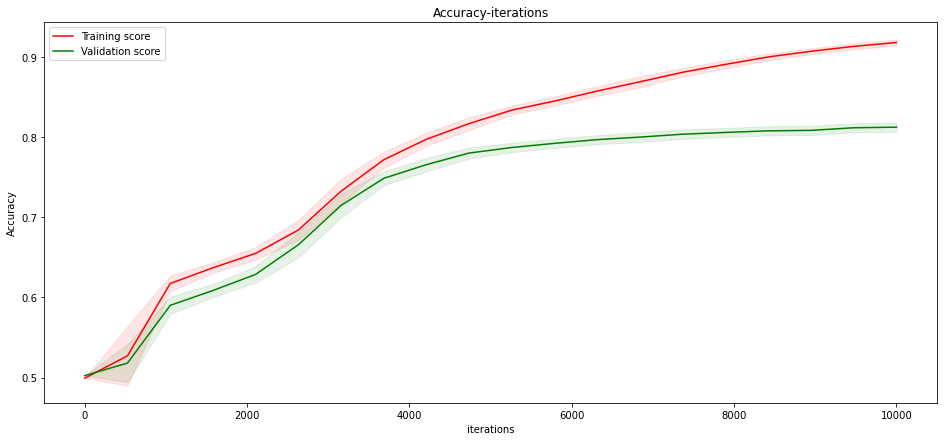

In [22]:
#learning curve visualization
train_acc = np.array(tarin_temp)
train_acc = np.resize(train_acc,(20,-1))
val_acc = np.array(test_temp)
val_acc = np.resize(val_acc,(20,-1))
train_acc_mean = train_acc.mean(axis=1)
train_acc_std = train_acc.std(axis=1)
val_acc_mean = val_acc.mean(axis=1)
val_acc_std = val_acc.std(axis=1)
plt.figure(figsize=(16, 7))
plt.title('Accuracy-iterations')
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.fill_between(np.linspace(0,training_epochs,20), train_acc_mean - train_acc_std,train_acc_mean + train_acc_std, alpha=0.1,color="r")
plt.fill_between(np.linspace(0,training_epochs,20), val_acc_mean - val_acc_std,val_acc_mean + val_acc_std, alpha=0.1,color="g")
plt.plot(np.linspace(0,training_epochs,20), train_acc_mean, color="r",label="Training score")
plt.plot(np.linspace(0,training_epochs,20), val_acc_mean, color="g",label="Validation score")
plt.legend(loc="best")

In [10]:
#restore model and check loss,accuracy and labels
with  tf.Session() as sess:
        saver = tf.train.import_meta_graph('model1/my-model-37800.meta')
        saver.restore(sess, tf.train.latest_checkpoint("model1/"))

        graph = tf.get_default_graph()
        input_images = graph.get_tensor_by_name('input_images:0')
        result = graph.get_tensor_by_name('result:0')
        feed_dict = {input_images:x_test, result:y_test}

        acc = graph.get_operation_by_name('acc').outputs[0]
        loss = graph.get_operation_by_name('loss').outputs[0]
        predict_label = graph.get_operation_by_name('predict_label').outputs[0]
        check =  graph.get_operation_by_name('check').outputs[0]
        acc,loss,predict_label,check = sess.run([acc,loss,predict_label,check], feed_dict)
        
        print("the accuracy is:",acc)
        print("the loss is:",loss)
        print("the predict_label is:",predict_label)
        print("the check result is:",check)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model1/my-model-37800
the accuracy is: 0.828
the loss is: 0.48083043
the predict_label is: [1 1 0 ... 0 1 1]
the check result is: [False  True False ...  True False  True]
